In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# For the dashboard
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import pandas as pd
import plotly.express as px

# Overview

In this notebook I have created a dashboard giving an overview of the problems in Zürich. The map shows the location of all problems, what the problem is and the status of the problem. The user can filter by the type of problem, to see only the problems of interest, e.g. only the problems with the type "Graffiti" that are still open.

### Why?/Usecases

Citizens can use this dashboard to see what problems there are in Zurich, to stay up to date.

If a citizen is planning a late picnic in Irchel Park, they can check the dashboard to see if there are any problems in the park, e.g.:

if the lighting is broken, they might have to bright a lamp themselves.
there was one (albeit erroneous) report of a type of mosquito that can carry the dangerous Dengue fever, so they might want to choose a different park.


Benevolent citizens can filter by cases of graffiti that are not fixed yet and clean it up themselves.

If you are moving to Wiedikon and don't know much about the area, you can check the dashboard to see what problems there are in the area, and if they are being fixed.


For the people behind "Zurich wie neu", this dashboard could maybe offer a different overview of the city's problems.


### Data

This data set is from "Zurich wie neu" (Zurich like new), a program where citizens can report problems or flaws in the city. Stadt Zurich will then respond to the report and ideally fix the problem.

The (important) columns in the data set are:

coordinates (e,n): the coordinates of the problem in Swiss (east, north) format

service_code: the type of problem in 10 categories

status: the status of the problem

requested_datetime: the date and time the problem was reported

updated_datetime: the date and time the problem was updated. If updated to "fixed" it indicates the time it took to fix the problem.

detail: a description of the problem from the citizen

media_url: a link to a picture of the problem uploaded by the citizen


### Analysis

The goal is to find some interesting insights in the data set and put it into a dashboard. The dashboard will be created using Plotly Dash.

### Dashboard Goals

The dashboard should:

Have a map of Zurich with the problems marked on it. The user should be able to select a problem and see the type, status, and when it was reported and updated.

Have a dropdown menu to filter by the type of problem.



## Inspect data

In [2]:
data_raw = pd.read_csv('C:/Users/simon/Desktop/Code/Zuri_wie_neu_dashboard/ZWN_data/data/stzh_zwn_meldungen_p.csv')

data_raw.head()

,objectid,service_request_id,e,n,service_code,status,detail,media_url,interface_used,requested_datetime,agency_sent_datetime,updated_datetime,service_notice,title,description,service_name,url,geometry
0,1,1,2678968.0,1247548.0,Strasse/Trottoir/Platz,fixed - council,Auf dem Asphalt des Bürgersteigs hat es eine E...,NaN,Web interface,20130314151615,2.013040e+13,20130412075930,Diese Reparatur wird von uns in den kommenden ...,Auf dem Asp,Auf dem Asp: Auf dem Asphalt des Bürgersteigs ...,Strasse/Trottoir/Platz,https://www.zueriwieneu.ch/report/1,POINT (2678968 1247548)
1,2,2,2680746.0,1249916.0,Strasse/Trottoir/Platz,fixed - council,Vermessungspunkt ist nicht mehr bündig mit dem...,NaN,Web interface,20130314151757,2.013033e+13,20130412080022,Diese Reparatur wird von uns in den kommenden ...,Vermessungs,Vermessungs: Vermessungspunkt ist nicht mehr b...,Strasse/Trottoir/Platz,https://www.zueriwieneu.ch/report/2,POINT (2680746 1249916)
2,3,4,2684605.0,1251431.0,Strasse/Trottoir/Platz,fixed - council,Beim Trottoir sind einige Randsteine defekt un...,https://www.zueriwieneu.ch/photo/4.0.jpeg?bfbb...,Web interface,20130315091416,2.013032e+13,20130412080810,Diese Reparatur wird von uns in den kommenden ...,Beim Trotto,Beim Trotto: Beim Trottoir sind einige Randste...,Strasse/Trottoir/Platz,https://www.zueriwieneu.ch/report/4,POINT (2684605 1251431)
3,4,5,2681754.0,1250376.0,Strasse/Trottoir/Platz,fixed - council,Auf dem Parkplatz beim Waidspital sind einige ...,https://www.zueriwieneu.ch/photo/5.0.jpeg?e309...,Web interface,20130315091715,2.013032e+13,20130412080905,Diese Reparatur wird von uns in den kommenden ...,Auf dem Par,Auf dem Par: Auf dem Parkplatz beim Waidspital...,Strasse/Trottoir/Platz,https://www.zueriwieneu.ch/report/5,POINT (2681754 1250376)
4,5,6,2683094.0,1247762.0,Abfall/Sammelstelle,fixed - council,Arbeitskiste ist rund herum verschmiert,https://www.zueriwieneu.ch/photo/6.0.jpeg?8e65...,Web interface,20130315103653,2.013042e+13,20130423135033,Dieses Graffiti wird von uns in den kommenden ...,Arbeitskist,Arbeitskist: Arbeitskiste ist rund herum versc...,Abfall/Sammelstelle,https://www.zueriwieneu.ch/report/6,POINT (2683094 1247762)


## Data preprocessing

In [3]:
# Remove duplicate column
(data_raw['service_name'] == data_raw['service_code']).all()
data = data_raw.drop('service_code', axis=1)

In [4]:
# Convert timestamp to datetime format
date_columns = ['requested_datetime', 'agency_sent_datetime', 'updated_datetime']

for col in date_columns:
    data[col] = pd.to_datetime(data[col], format='%Y%m%d%H%M%S')

data[date_columns]

,requested_datetime,agency_sent_datetime,updated_datetime
0,2013-03-14 15:16:15,2013-04-04 07:25:05,2013-04-12 07:59:30
1,2013-03-14 15:17:57,2013-03-26 14:05:05,2013-04-12 08:00:22
2,2013-03-15 09:14:16,2013-03-15 09:55:05,2013-04-12 08:08:10
3,2013-03-15 09:17:15,2013-03-20 10:05:05,2013-04-12 08:09:05
4,2013-03-15 10:36:53,2013-04-22 18:25:05,2013-04-23 13:50:33
...,...,...,...
54140,2024-09-04 16:29:01,2024-09-04 16:32:05,2024-09-04 19:00:15
54141,2024-09-04 16:43:28,2024-09-04 16:47:04,2024-09-04 19:14:00
54142,2024-09-04 16:46:14,2024-09-04 17:22:04,2024-09-04 17:22:04
54143,2024-09-04 16:51:49,2024-09-04 16:52:05,2024-09-04 16:53:07


In [5]:
data['media_url'].fillna('No media', inplace=True)

In [6]:
# Add time it took to fix the problem
data[data['status'] == 'fixed - council'][['requested_datetime', 'updated_datetime']]
data['service_time'] = np.zeros(data.shape[0])
data['service_time'] = data['updated_datetime'] - data['requested_datetime']
data['service_time'] = data['service_time'].dt.total_seconds() / 60 / 60

# Add report_day as a column
data['report_day'] = data['requested_datetime'].dt.day_name()
# Add report_year
data['report_year'] = data['requested_datetime'].dt.year

# Ensure years and weekdays are ordered for plotting later
years = sorted(data['requested_datetime'].dt.year.unique())
weekdays = sorted(data['requested_datetime'].dt.day_name().unique(), key=lambda x: ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'].index(x))


Converting the coordinates from the swiss east and north format to latitude and longitude.

In [7]:
from pyproj import Transformer

# Define the transformer for converting CH1903+ / LV95 to WGS84
transformer = Transformer.from_crs("EPSG:2056", "EPSG:4326", always_xy=True)


# Function to transform coordinates
def transform_coordinates(row):
    longitude, latitude = transformer.transform(row['e'], row['n'])
    return pd.Series([longitude, latitude], index=['longitude', 'latitude'])

# Apply the function to each row in the DataFrame
data[['longitude', 'latitude']] = data.apply(transform_coordinates, axis=1)


In [8]:
import pandas as pd
from shapely.wkt import loads
from shapely.geometry import Point
from pyproj import Transformer

# Define the transformer for converting CH1903+ / LV95 to WGS84
transformer = Transformer.from_crs("EPSG:2056", "EPSG:4326", always_xy=True)

# Function to transform coordinates
def transform_coordinates(row):
    longitude, latitude = transformer.transform(row['e'], row['n'])
    return pd.Series([longitude, latitude], index=['longitude', 'latitude'])

# Apply the function to each row in the DataFrame
data[['longitude', 'latitude']] = data.apply(transform_coordinates, axis=1)


In [9]:
# Add media support: Show the picture if possible.
df = data[['longitude', 'latitude', 'status', 'requested_datetime', 'updated_datetime', 'service_time', 'service_name', 'report_day', 'report_year', 'detail', 'media_url', 'service_notice']]
df

,longitude,latitude,status,requested_datetime,updated_datetime,service_time,service_name,report_day,report_year,detail,media_url,service_notice
0,8.484226,47.374038,fixed - council,2013-03-14 15:16:15,2013-04-12 07:59:30,688.720833,Strasse/Trottoir/Platz,Thursday,2013,Auf dem Asphalt des Bürgersteigs hat es eine E...,No media,Diese Reparatur wird von uns in den kommenden ...
1,8.508193,47.395119,fixed - council,2013-03-14 15:17:57,2013-04-12 08:00:22,688.706944,Strasse/Trottoir/Platz,Thursday,2013,Vermessungspunkt ist nicht mehr bündig mit dem...,No media,Diese Reparatur wird von uns in den kommenden ...
2,8.559589,47.408259,fixed - council,2013-03-15 09:14:16,2013-04-12 08:08:10,670.898333,Strasse/Trottoir/Platz,Friday,2013,Beim Trottoir sind einige Randsteine defekt un...,https://www.zueriwieneu.ch/photo/4.0.jpeg?bfbb...,Diese Reparatur wird von uns in den kommenden ...
3,8.521627,47.399131,fixed - council,2013-03-15 09:17:15,2013-04-12 08:09:05,670.863889,Strasse/Trottoir/Platz,Friday,2013,Auf dem Parkplatz beim Waidspital sind einige ...,https://www.zueriwieneu.ch/photo/5.0.jpeg?e309...,Diese Reparatur wird von uns in den kommenden ...
4,8.538891,47.375455,fixed - council,2013-03-15 10:36:53,2013-04-23 13:50:33,939.227778,Abfall/Sammelstelle,Friday,2013,Arbeitskiste ist rund herum verschmiert,https://www.zueriwieneu.ch/photo/6.0.jpeg?8e65...,Dieses Graffiti wird von uns in den kommenden ...
...,...,...,...,...,...,...,...,...,...,...,...,...
54140,8.520284,47.403434,fixed - council,2024-09-04 16:29:01,2024-09-04 19:00:15,2.520556,Schädlinge,Wednesday,2024,Bei Waldspaziergang durch Tigermückenschwarm v...,https://www.zueriwieneu.ch/photo/60666.0.jpeg?...,Vielen Dank für Ihre Meldung. <br/> <br/> Weg...
54141,8.515094,47.379997,fixed - council,2024-09-04 16:43:28,2024-09-04 19:14:00,2.508889,Schädlinge,Wednesday,2024,Sehr geehrte Damen und Herren <br/> <br/> Sie...,https://www.zueriwieneu.ch/photo/60668.0.jpeg?...,Guten Abend <br/> <br/> Das glauben wir Ihnen...
54142,8.507043,47.352313,confirmed,2024-09-04 16:46:14,2024-09-04 17:22:04,0.597222,Grünflächen/Spielplätze,Wednesday,2024,"Flacher Wassertrog, ursprünglich zur Schuhrein...",No media,NaN
54143,8.524451,47.372560,fixed - council,2024-09-04 16:51:49,2024-09-04 16:53:07,0.021667,Abfall/Sammelstelle,Wednesday,2024,Diese KACK Velo versperrt seit Wochen den Velo...,https://www.zueriwieneu.ch/photo/60670.0.jpeg?...,Die Zweiradordnung wird Ihr Anliegen prüfen un...


# Adding Kreise to the data

In [10]:
from shapely import wkt
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

In [11]:
kreis_df = pd.read_csv('C:/Users/simon/Desktop/Code/Zuri_wie_neu_dashboard/kreis_data/data/stzh_adm_stadtkreise_a.csv')
kreis_df.rename(columns={"bezeichnung": "kreis_name"}, inplace=True)

kreis_df.sort_values('name', inplace=True)
kreis_df.drop(['objid','entstehung'], axis=1, inplace=True)
kreis_df.reset_index(drop=True, inplace=True)
kreis_df['geometry'] = kreis_df['geometry'].apply(wkt.loads)


transformer = Transformer.from_crs("EPSG:2056", "EPSG:4326", always_xy=True)

# Function to transform coordinates
def transform_coordinates(row):
    longitude, latitude = transformer.transform(row['e'], row['n'])
    return pd.Series([longitude, latitude], index=['longitude', 'latitude'])


def transform_polygon(polygon):
    # Transform all coordinates in the polygon
    coords = list(polygon.exterior.coords)
    transformed_coords = [transformer.transform(x, y) for x, y in coords]
    return Polygon(transformed_coords)

#Translate coordinates to lat,lon
kreis_df['geometry'] = kreis_df['geometry'].apply(transform_polygon)  



# Convert df's lat/lon to Shapely Point objects
df['point'] = df.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)

# Function to classify each point based on polygons in kreis_df
def classify_point(point, polygons):
    for idx, polygon in enumerate(polygons):
        if polygon.contains(point):
            return idx
    return None


C:\Users\simon\AppData\Local\Temp\ipykernel_13052\4007770953.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['point'] = df.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)


In [12]:
# Function to classify points based on polygons
def classify_point(row):
    for _, polygon_row in kreis_df.iterrows():
        if row['point'].within(polygon_row['geometry']):
            return polygon_row['name']
    return 'Unknown'

# Classify each point in the data
df['kreis_name'] = df.apply(classify_point, axis=1)

# Now 'data' DataFrame includes 'kreis_name' which indicates which kreis each point falls into.


C:\Users\simon\AppData\Local\Temp\ipykernel_13052\407688397.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['kreis_name'] = df.apply(classify_point, axis=1)


In [13]:
df = df[df['kreis_name'] != 'Unknown']

## Add extra kreis data

In [14]:
kdf_raw = pd.read_csv('C:/Users/simon/Desktop/Code/Zuri_wie_neu_dashboard/kreis_data/kreis_population_data.csv', skiprows=1)
kdf_raw.columns = kdf_raw.iloc[0]
kdf_raw.drop(0, inplace=True)
kdf_raw.reset_index(drop=True, inplace=True)
kdf_raw[['kreis_name', 'Wohnbevolkerung', 'Beschaftige', 'Arbeitsstatten', 'Verpflegungsbetriebe']] = kdf_raw[['kreis_name', 'Wohnbevolkerung', 'Beschaftige', 'Arbeitsstatten', 'Verpflegungsbetriebe']].astype(int)
kdf_raw['Auslanderanteil'] = kdf_raw['Auslanderanteil'].astype(float)
kdf = kdf_raw.copy().iloc[1:]
df.loc[:,'kreis_name'] = df.loc[:,'kreis_name'].astype(int)

# Analysis

In [23]:
plt.rcParams['figure.figsize'] = (17, 10)


In [1]:
plt.hist(df['service_name'])


NameError: name 'plt' is not defined

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Extract month from the requested_datetime
df['month'] = df['requested_datetime'].dt.month

# Aggregate the data to get the count of reports for each combination of service_name and month
pivot_table = df.pivot_table(index='service_name', columns='month', aggfunc='size', fill_value=0)

NameError: name 'df' is not defined

In [ ]:
# Create the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, annot=True, fmt="d", cmap="YlGnBu")

# Add title and labels
plt.title('Number of Reports by Service Name and Month')
plt.xlabel('Month')
plt.ylabel('Service Name')

# Save the plot as a PNG with tight bounding box
#plt.savefig('service_name_month_heatmap.png', bbox_inches='tight')

# Show the plot
plt.show()

In [3]:

# Extract month from the requested_datetime
df['month'] = df['requested_datetime'].dt.month

# Filter the data to include only rows with 'fixed - council' status
fixed_council_df = df[df['status'] == 'fixed - council']

# Aggregate the data to get the count of 'fixed - council' reports for each combination of service_name and month
fixed_council_counts = fixed_council_df.pivot_table(index='service_name', columns='month', aggfunc='size', fill_value=0)

# Aggregate the data to get the total count of reports for each combination of service_name and month
total_counts = df.pivot_table(index='service_name', columns='month', aggfunc='size', fill_value=0)

# Calculate the percentage of 'fixed - council' reports
percentage_fixed_council = (fixed_council_counts / total_counts) * 100

NameError: name 'df' is not defined

In [ ]:
# Create the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, annot=True, fmt="d", cmap="YlGnBu")

# Add title and labels
plt.title('Number of Reports by Service Name and Month')
plt.xlabel('Month')
plt.ylabel('Service Name')

# Save the plot as a PNG with tight bounding box
plt.savefig('service_name_month_heatmap.png', bbox_inches='tight')

# Show the plot
plt.show()

In [ ]:
# Create the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(percentage_fixed_council, annot=True, fmt=".2f", cmap="YlGnBu")

# Add title and labels
plt.title('Percentage of Fixed - Council Reports by Service Name and Month')
plt.xlabel('Month')
plt.ylabel('Service Name')

# Save the plot as a PDF with tight bounding box
plt.savefig('percentage_fixed_council_heatmap.png', bbox_inches='tight')

# Show the plot
plt.show()

In [ ]:
# Extract month from the requested_datetime
df['month'] = df['requested_datetime'].dt.month

# Aggregate the data to get the count of reports for each combination of kreis_name and month
pivot_table = df.pivot_table(index='kreis_name', columns='month', aggfunc='size', fill_value=0)

# Create the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, annot=True, fmt="d", cmap="YlGnBu")

# Add title and labels
plt.title('Number of Reports by Kreis Name and Month')
plt.xlabel('Month')
plt.ylabel('Kreis Name')

#plt.savefig('kreis_name_month_heatmap.png', bbox_inches='tight')

# Show the plot
plt.show()

In [ ]:
# Aggregate the data to calculate the average service time for each combination of service_name and kreis_name
pivot_table = df.pivot_table(index='service_name', columns='kreis_name', values='service_time', aggfunc='mean', fill_value=0)
# Create the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, annot=True, fmt=".2f", cmap="YlGnBu")

# Add title and labels
plt.title('Average Service Time by Service Name and Kreis Name')
plt.xlabel('Kreis Name')
plt.ylabel('Service Name')

#plt.savefig('service_name_kreis_name_service_time_heatmap.png', bbox_inches='tight')

# Show the plot
plt.show()

In [ ]:

pivot_table = df.pivot_table(index='service_name', columns='kreis_name', aggfunc='size', fill_value=0)

# Create the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, annot=True, fmt="d", cmap="YlGnBu")

# Add title and labels
plt.title('Number of Reports by Service Name and Kreis Name')
plt.xlabel('Kreis Name')
plt.ylabel('Service Name')

#plt.savefig('service_name_kreis_name_reports_heatmap.png', bbox_inches='tight')

# Show the plot
plt.show()

In [ ]:
for d in df['service_name'].unique():
    print('Average Service Time for',d, int(df[df['service_name'] == d]['service_time'].mean()),'hours')

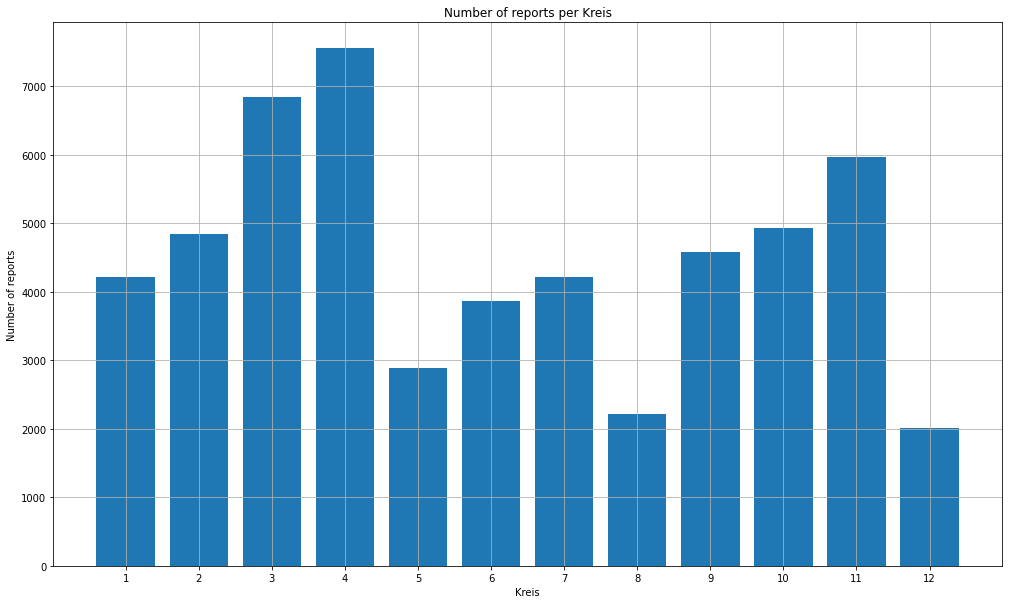

In [24]:
plt.bar(kdf.index, merged_df.groupby('kreis_name')['service_name'].size())
plt.xlabel('Kreis')
plt.ylabel('Number of reports')
plt.title('Number of reports per Kreis')
plt.xticks(kdf.index, kdf['kreis_name'])
plt.grid();

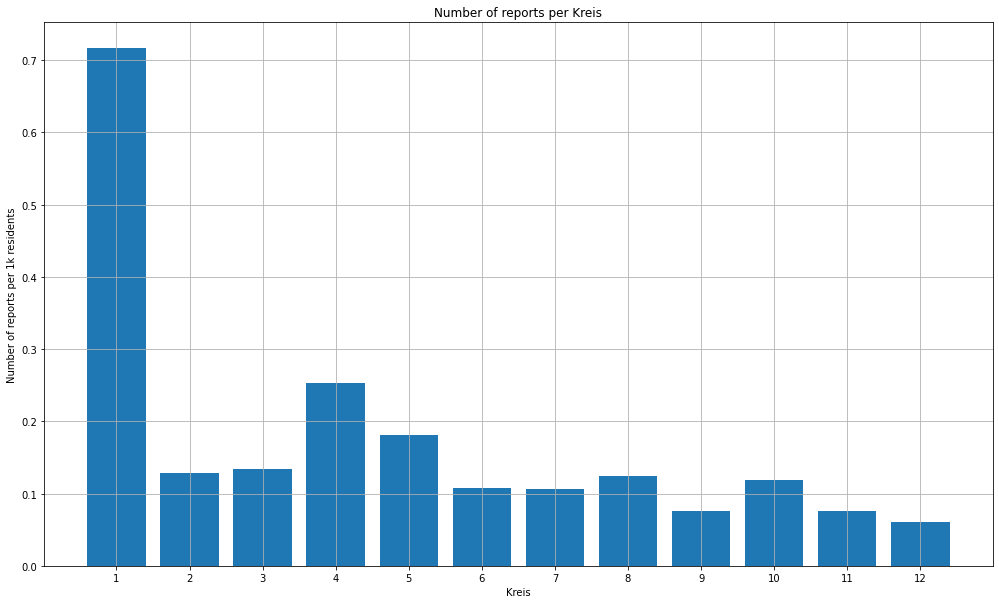

In [25]:
plt.bar(kdf.index, merged_df.groupby('kreis_name')['service_name'].size()/kdf['Wohnbevolkerung'])
plt.xlabel('Kreis')
plt.ylabel('Number of reports per 1k residents')
plt.title('Number of reports per Kreis')
plt.xticks(kdf.index, kdf['kreis_name'])
plt.grid();

In [208]:
kdf['Wohnbevolkerung']

1      5890
2     37639
3     50950
4     29944
5     15874
6     35688
7     39647
8     17860
9     59841
10    41411
11    78801
12    33537
Name: Wohnbevolkerung, dtype: int32

-0.0868587546384014


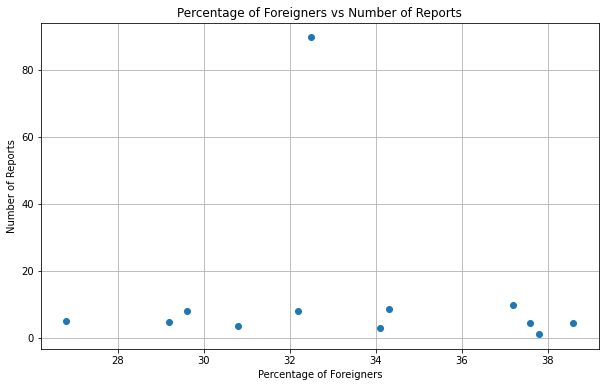

In [20]:
import matplotlib.pyplot as plt

# Merge df and kdf on 'kreis_name'
merged_df = df[df['kreis_name'] != 'Unknown'].merge(kdf.iloc[1:], on='kreis_name', how='left')

# Calculate number of reports per kreis
reports_per_kreis = merged_df[merged_df['service_name'] == 'Graffiti'].groupby('kreis_name').size()
reports_per_1k_inhabitants = reports_per_kreis/kdf['Wohnbevolkerung']*1000
print(reports_per_1k_inhabitants.corr(kdf['Auslanderanteil']))

# Scatter plot of Auslanderanteil (percentage_foreigners) vs number of reports
plt.figure(figsize=(10, 6))
plt.scatter(kdf['Auslanderanteil'], reports_per_1k_inhabitants)
plt.title("Percentage of Foreigners vs Number of Reports")
plt.xlabel("Percentage of Foreigners")
plt.ylabel("Number of Reports")
plt.grid(True)
plt.show()

In [175]:
kdf

,kreis_name,Auslanderanteil,Wohnbevolkerung,Beschaftige,Arbeitsstatten,Verpflegungsbetriebe
0,0,33.6,447082,536980,46671,2258
1,1,32.5,5890,76043,5591,467
2,2,34.3,37639,50704,4314,137
3,3,30.8,50950,47069,4627,231
4,4,37.2,29944,49627,4867,387
5,5,32.2,15874,61148,3278,234
6,6,29.6,35688,29147,3333,105
7,7,29.2,39647,34261,4002,86
8,8,37.6,17860,33041,4211,112
9,9,34.1,59841,69491,4265,148


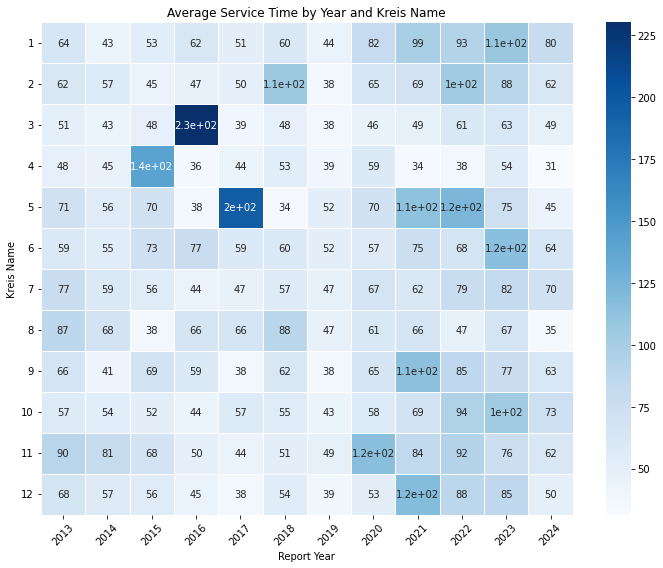

In [232]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming your DataFrame is named 'df'
# First, group by 'report_year' and 'kreis_name', and calculate the average 'service_time'
average_service_time = df.groupby(['report_year', 'kreis_name'])['service_time'].mean().reset_index()

# Pivot the DataFrame to create the matrix where rows are 'kreis_name' and columns are 'report_year'
service_time_matrix = average_service_time.pivot(index='kreis_name', columns='report_year', values='service_time')

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(service_time_matrix, annot=True, cmap='Blues', linewidths=0.5)
plt.title('Average Service Time by Year and Kreis Name')
plt.xlabel('Report Year')
plt.ylabel('Kreis Name')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()

# Show the plot
plt.show()


C:\Users\simon\AppData\Local\Temp\ipykernel_7040\23906155.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['is_solved'] = df['status'] == 'fixed - council'


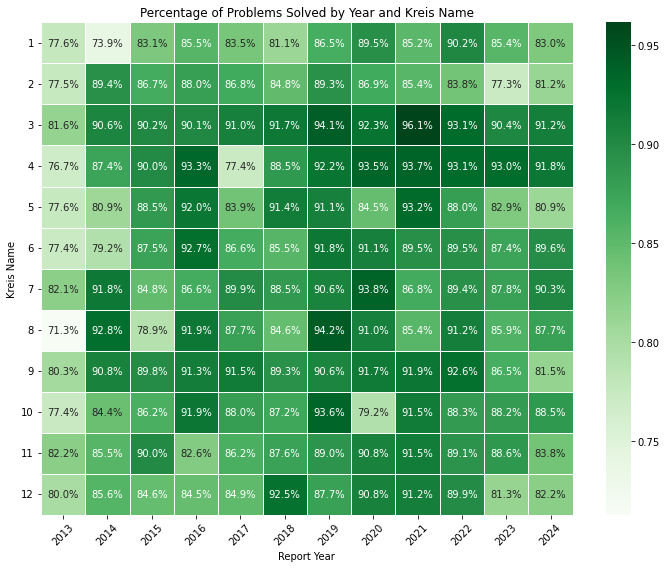

In [233]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming your DataFrame is named 'df'

# Filter only relevant rows where 'status' is either 'fixed - council' or something else
df['is_solved'] = df['status'] == 'fixed - council'

# Group by 'report_year' and 'kreis_name', then calculate the percentage of solved problems
solved_percentage = df.groupby(['report_year', 'kreis_name'])['is_solved'].mean().reset_index()

# Pivot the DataFrame to create the matrix where rows are 'kreis_name' and columns are 'report_year'
solved_matrix = solved_percentage.pivot(index='kreis_name', columns='report_year', values='is_solved')

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(solved_matrix, annot=True, cmap='Greens', fmt='.1%', linewidths=0.5)
plt.title('Percentage of Problems Solved by Year and Kreis Name')
plt.xlabel('Report Year')
plt.ylabel('Kreis Name')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()

# Show the plot
plt.show()


C:\Users\simon\AppData\Local\Temp\ipykernel_7040\2148201653.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['is_solved'] = df['status'] == 'fixed - council'


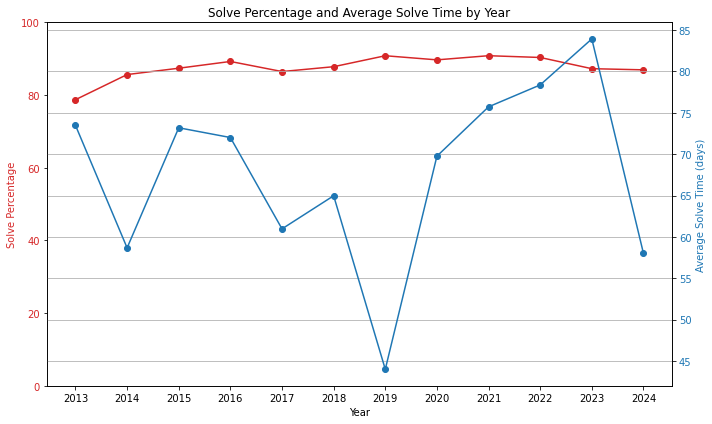

In [239]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming your DataFrame is named 'df'

# Create a new column 'is_solved' for solved problems (status == 'fixed - council')
df['is_solved'] = df['status'] == 'fixed - council'

# Group by 'report_year' and calculate the percentage solved and average solve time
yearly_stats = df.groupby('report_year').agg(
    solve_percentage=('is_solved', 'mean'),
    average_solve_time=('service_time', lambda x: x[df['is_solved']].mean())
).reset_index()

# Plot the solve percentage and average solve time on two y-axes
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the solve percentage
color = 'tab:red'
ax1.set_xlabel('Year')
ax1.set_ylabel('Solve Percentage', color=color)
ax1.plot(yearly_stats['report_year'], yearly_stats['solve_percentage'] * 100, color=color, marker='o', label='Solve Percentage')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim(0, 100)  # Set limits for the percentage scale

# Create a second y-axis for average solve time
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Average Solve Time (days)', color=color)
ax2.plot(yearly_stats['report_year'], yearly_stats['average_solve_time'], color=color, marker='o', label='Average Solve Time')
ax2.tick_params(axis='y', labelcolor=color)

# Add a title and grid
plt.title('Solve Percentage and Average Solve Time by Year')
plt.xticks(np.sort(yearly_stats['report_year'].unique()))
plt.grid()

# Show the plot
plt.tight_layout()
plt.show()


In [64]:
df['kreis_name']

0         9
1        10
2        12
3        10
4         1
         ..
54140    10
54141     4
54142     3
54143     4
54144     7
Name: kreis_name, Length: 54145, dtype: object

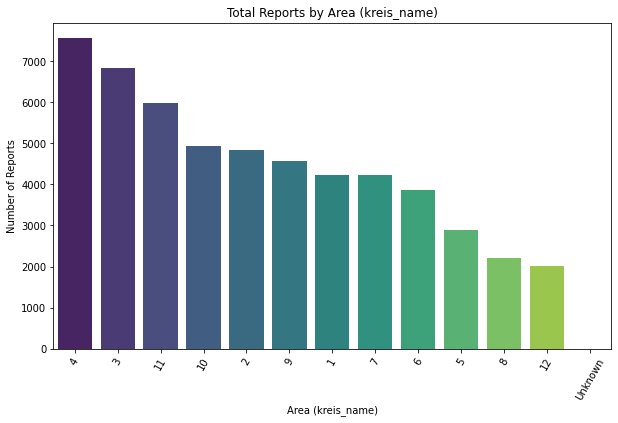

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Report frequency by area (kreis_name)
report_freq_by_area = df['kreis_name'].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=report_freq_by_area.index, y=report_freq_by_area.values, palette='viridis')
plt.xticks(rotation=60)
plt.title('Total Reports by Area (kreis_name)')
plt.xlabel('Area (kreis_name)')
plt.ylabel('Number of Reports')
plt.show()


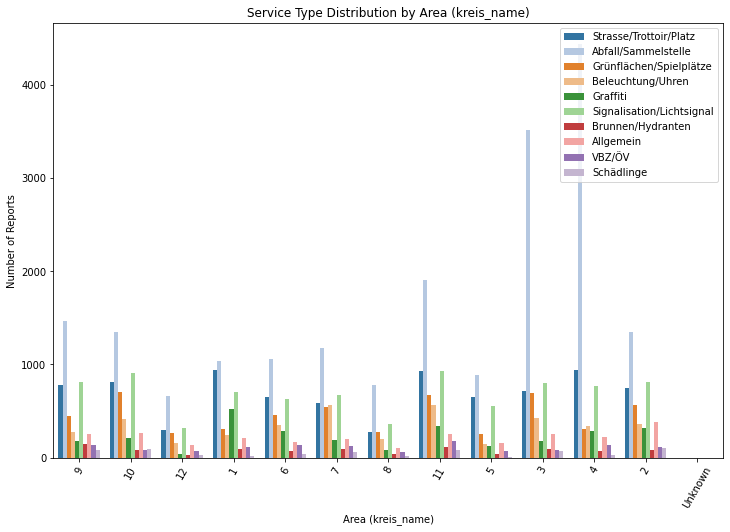

In [14]:
# Service type distribution by area
plt.figure(figsize=(12, 8))
sns.countplot(data=df, x='kreis_name', hue='service_name', palette='tab20')
plt.xticks(rotation=60)
plt.title('Service Type Distribution by Area (kreis_name)')
plt.xlabel('Area (kreis_name)')
plt.ylabel('Number of Reports')
plt.legend(loc='upper right')
plt.show()


In [27]:
avg_service_time_by_area.index

Index([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 'Unknown'], dtype='object', name='kreis_name')

In [31]:
kreis_x

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]

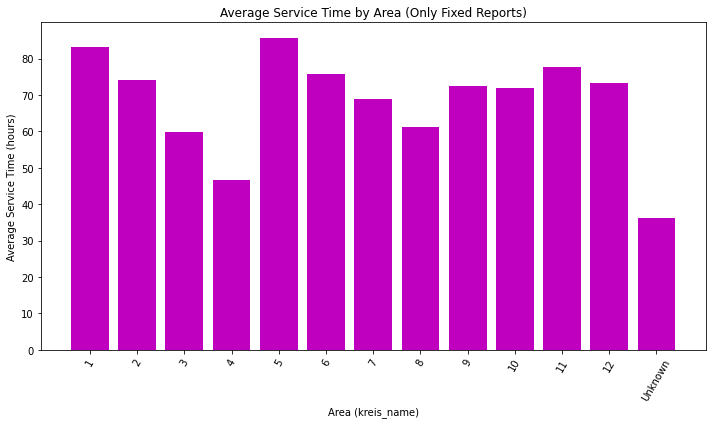

In [32]:
# Average service time by area (only for fixed reports)
fixed_reports = df[df['status'] == 'fixed - council']
avg_service_time_by_area = fixed_reports.groupby('kreis_name')['service_time'].mean()
kreis_x = avg_service_time_by_area.index[:-1].tolist() + [13]
kreis_x_labels = kreis_x[:-1] + ['Unknown']
plt.figure(figsize=(10, 6))
plt.bar(kreis_x, avg_service_time_by_area.values, color='m')
plt.xticks(rotation=60, ticks=kreis_x, labels=kreis_x_labels)
plt.title('Average Service Time by Area (Only Fixed Reports)')
plt.xlabel('Area (kreis_name)')
plt.ylabel('Average Service Time (hours)')
plt.tight_layout()
plt.show()


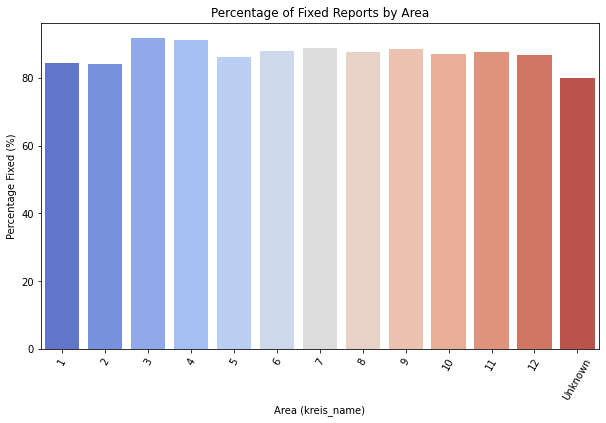

In [33]:
# Percentage of fixed reports by area
total_reports_by_area = df.groupby('kreis_name')['status'].count()
fixed_reports_by_area = df[df['status'] == 'fixed - council'].groupby('kreis_name')['status'].count()
percentage_fixed_by_area = (fixed_reports_by_area / total_reports_by_area) * 100

plt.figure(figsize=(10, 6))
sns.barplot(x=percentage_fixed_by_area.index, y=percentage_fixed_by_area.values, palette='coolwarm')
plt.xticks(rotation=60)
plt.title('Percentage of Fixed Reports by Area')
plt.xlabel('Area (kreis_name)')
plt.ylabel('Percentage Fixed (%)')
plt.show()


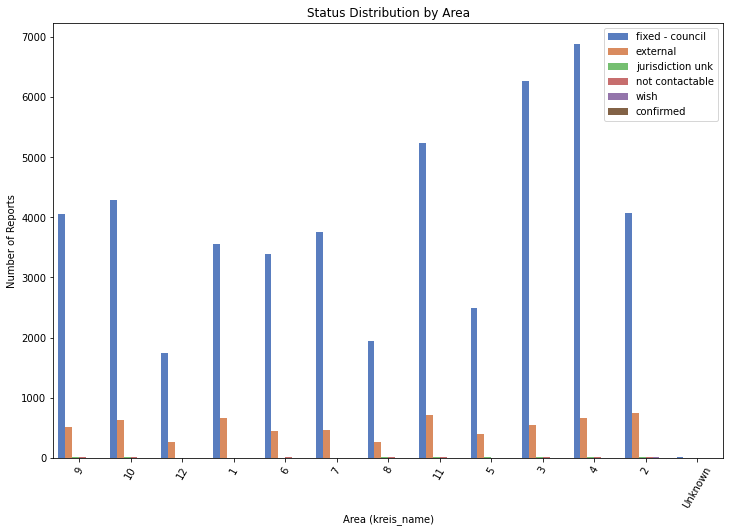

In [18]:
# Status comparison by area
plt.figure(figsize=(12, 8))
sns.countplot(data=df, x='kreis_name', hue='status', palette='muted')
plt.xticks(rotation=60)
plt.title('Status Distribution by Area')
plt.xlabel('Area (kreis_name)')
plt.ylabel('Number of Reports')
plt.legend(loc='upper right')
plt.show()


C:\Users\simon\AppData\Local\Temp\ipykernel_7040\3190044075.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['report_month'] = df['requested_datetime'].dt.to_period('M')


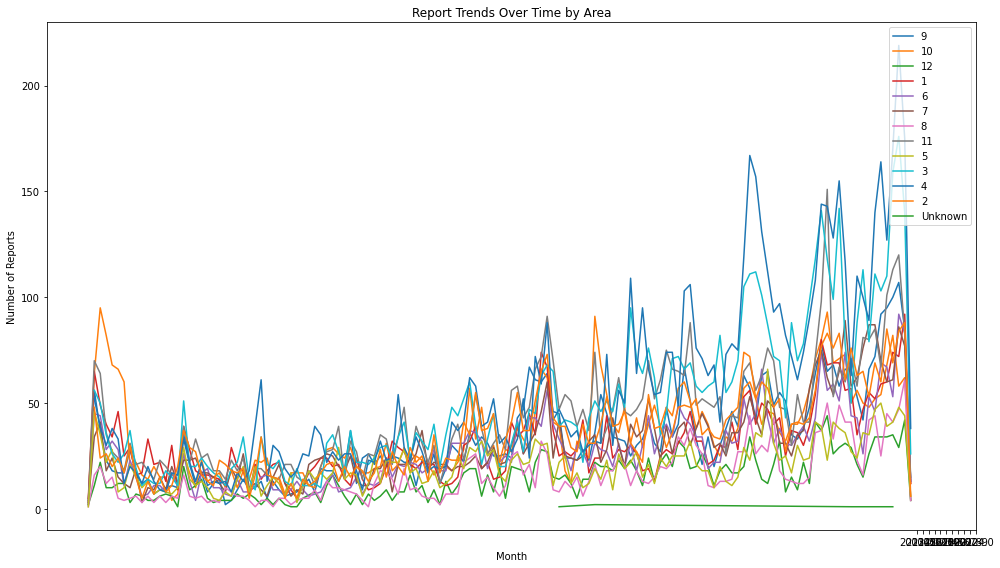

In [36]:
# Convert datetime to a monthly period
df['report_month'] = df['requested_datetime'].dt.to_period('M')

# Trend of reports over time by area
plt.figure(figsize=(14, 8))
for kreis in df['kreis_name'].unique():
    kreis_data = df[df['kreis_name'] == kreis]['report_month'].value_counts().sort_index()
    plt.plot(kreis_data.index.astype(str), kreis_data.values, label=kreis)

plt.xticks([str(x) for x in np.linspace(2013, 2024, 11)])
plt.title('Report Trends Over Time by Area')
plt.xlabel('Month')
plt.ylabel('Number of Reports')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()


In [39]:
avg_service_time_by_area.head()

kreis_name
1    83.162249
2    74.151308
3    59.780826
4    46.659662
5    85.645194
Name: service_time, dtype: float64

0.12278448633090949


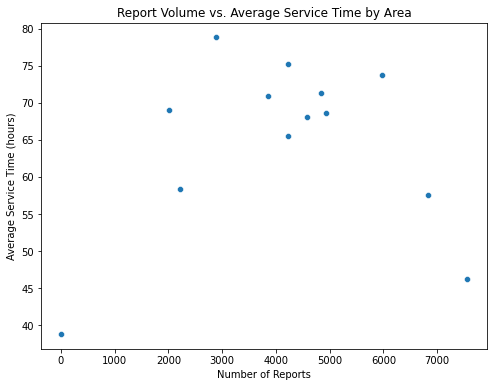

In [44]:
# Correlation between number of reports and average service time
report_volume = df.groupby('kreis_name')['service_name'].count()
service_time = df.groupby('kreis_name')['service_time'].mean()
print(report_volume.corr(service_time))
plt.figure(figsize=(8, 6))
sns.scatterplot(x=report_volume, y=service_time)
plt.title('Report Volume vs. Average Service Time by Area')
plt.xlabel('Number of Reports')
plt.ylabel('Average Service Time (hours)')
plt.show()


In [52]:
kreis_data

day_of_week
Monday        43.183700
Tuesday       88.182127
Wednesday     58.518747
Thursday      74.716915
Friday       109.745954
Saturday      97.594270
Sunday        56.051020
Name: service_time, dtype: float64

C:\Users\simon\AppData\Local\Temp\ipykernel_7040\3320928451.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['day_of_week'] = df['requested_datetime'].dt.day_name()


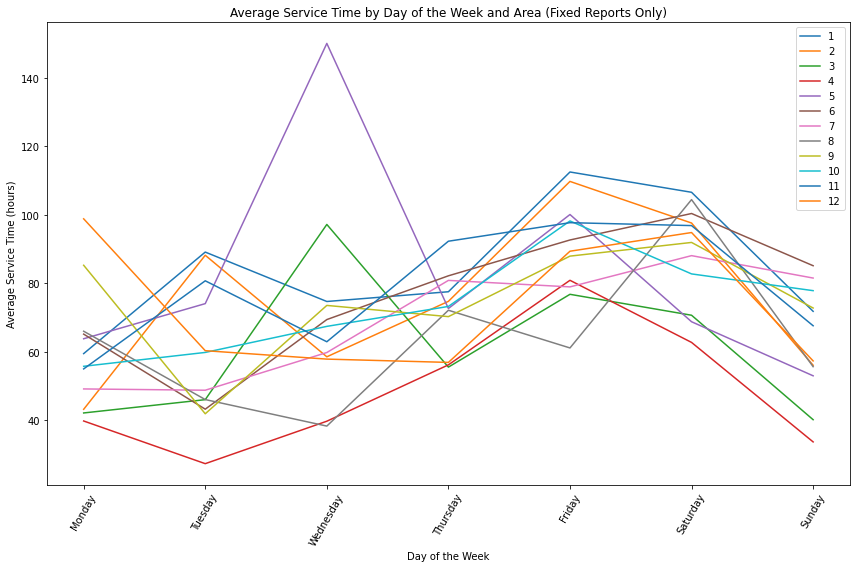

In [55]:
# Analyze service time by day of the week and area
df['day_of_week'] = df['requested_datetime'].dt.day_name()

plt.figure(figsize=(12, 8))
for kreis in np.sort(df['kreis_name'].unique()[:-1]):
    kreis_data = df[(df['status'] == 'fixed - council') & (df['kreis_name'] == kreis)].groupby('day_of_week')['service_time'].mean().reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
    plt.plot(kreis_data.index, kreis_data.values, label=kreis)

plt.title('Average Service Time by Day of the Week and Area (Fixed Reports Only)')
plt.xlabel('Day of the Week')
plt.ylabel('Average Service Time (hours)')
plt.xticks(rotation=60)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()
